In [15]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
conn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df_predictions = pd.read_sql_query("SELECT * FROM Predictions", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


In [56]:
import pandas as pd
import numpy as np

class QuinielaDataframe:

    def __init__(self, dataframe):

        self.df = dataframe
        self._clean_data()
        self._generate_team_info()

    def generate_features(self, list_features=[]):

        feature_generator = FeatureGenerator()
        feature_generator.apply_features(self, list_features)

    def generate_matchday_dataframe(self):
        
        return MatchdayDataframe(self)
    
    
    def _clean_data(self):

        self.df[['home_score', 'away_score']] = self.df['score'].str.split(':', expand=True)
        self.df['home_score'] = pd.to_numeric(self.df['home_score'])
        self.df['away_score'] = pd.to_numeric(self.df['away_score'])
        
        self.df['result'] = self.df.apply(lambda row: '1' if row['home_score'] > row['away_score']
                                          else '2' if row['home_score'] < row['away_score']
                                          else 'X', axis=1)
        
        self.df["season"] = pd.to_numeric(self.df["season"].str[-4:])

    def _generate_team_info(self):

        self._encoding_win()
        self._generate_matchday_standings()

    def _encoding_win(self):

        self.df['home_W'] = (self.df['result'] == '1').astype(int)
        self.df['home_L'] = (self.df['result'] == '2').astype(int)
        self.df['home_T'] = (self.df['result'] == 'X').astype(int)
        self.df['away_W'] = (self.df['result'] == '2').astype(int)
        self.df['away_L'] = (self.df['result'] == '1').astype(int)
        self.df['away_T'] = (self.df['result'] == 'X').astype(int)

    def _generate_matchday_standings(self):

        home_df = self.df[['season', 'division', 'matchday', 'home_team', 'home_score', 'away_score','home_score', 'away_score', 'home_W', 'home_L', 'home_T']]
        home_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','home_GF', 'home_GA', 'W', 'L', 'T']
        
        away_df = self.df[['season', 'division', 'matchday', 'away_team', 'away_score', 'home_score','away_score', 'home_score', 'away_W', 'away_L', 'away_T']]
        away_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','away_GF', 'away_GA', 'W', 'L', 'T']
        
        self.team_results = pd.concat([home_df, away_df])
        self.team_results.fillna(0, inplace=True)

        self.match_standings = self.team_results.sort_values(['season', 'division', 'team', 'matchday'])
        self.match_standings[['GF', 'GA','home_GF','home_GA','away_GF','away_GA', 'W', 'L', 'T']] = self.match_standings.groupby(['season', 'division', 'team'])[['GF', 'GA','home_GF','home_GA','away_GF','away_GA', 'W', 'L', 'T']].cumsum()

        self.match_standings['GD'] = self.match_standings['GF'] - self.match_standings['GA']
        self.match_standings['M'] = self.match_standings['W'] + self.match_standings['L'] + self.match_standings['T']
        self.match_standings['Pts'] = self.match_standings['W'] * 3 + self.match_standings['T']

        self.match_standings = self.match_standings.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'],
                                                                ascending=[True, True, True, False, False, False])

        self.match_standings.insert(3, 'rank', self.match_standings.groupby(['season', 'division', 'matchday'])['Pts']
                                    .rank(ascending=False, method='first'))


class MatchdayDataframe:
    
    def __init__(self, quiniela_df,versus_features = True):
        
        self.df = quiniela_df.df.copy()
        self.matchday_df = quiniela_df.match_standings.copy()
        self._prepare_matchday_stats()

        if(versus_features):
            feature_generator = FeatureGenerator()
            feature_generator.apply_features(self, ['versus_features'])

        self._clean_df()

    def _prepare_matchday_stats(self):

        home_stats = self.matchday_df[['season', 'division', 'matchday', 'team', 'rank', 
                                                       'avg_GF', 'avg_GA', 'home_avg_GF', 'home_avg_GA', 
                                                       'avg_last_points','rank_n_last_seasons']]
        
        away_stats = self.matchday_df[['season', 'division', 'matchday', 'team', 'rank', 
                                                       'avg_GF', 'avg_GA', 'away_avg_GF', 'away_avg_GA', 
                                                       'avg_last_points','rank_n_last_seasons']]

        home_stats = home_stats.rename(columns={
            'team': 'home_team',
            'rank': 'home_rank',
            'avg_GF': 'home_total_avg_GF',
            'avg_GA': 'home_total_avg_GA',
            'home_avg_GF': 'home_GF_avg',
            'home_avg_GA': 'home_GA_avg',
            'avg_last_points': 'home_avg_points_last_5',
            'rank_n_last_seasons' : 'home_rank_5_last_seasons'
        })

        away_stats = away_stats.rename(columns={
            'team': 'away_team',
            'rank': 'away_rank',
            'avg_GF': 'away_total_avg_GF',
            'avg_GA': 'away_total_avg_GA',
            'away_avg_GF': 'away_GF_avg',
            'away_avg_GA': 'away_GA_avg',
            'avg_last_points': 'away_avg_points_last_5',
            'rank_n_last_seasons' : 'away_rank_5_last_seasons'

        })
        
        self._adjust_matchday(home_stats,away_stats)

    def _adjust_matchday(self,home_stats,away_stats):
        
        self.df["matchday"] = self.df["matchday"] - 1
        
        self.df = self.df.merge(home_stats, on=['season', 'division', 'matchday', 'home_team'], how='left')
        self.df = self.df.merge(away_stats, on=['season', 'division', 'matchday', 'away_team'], how='left')
        
        self.df["matchday"] = self.df["matchday"] + 1

    def _clean_df(self):
        
        self.df.drop(['date', 'time',
       'score', 'home_score', 'away_score', 'home_W',
       'home_L', 'home_T', 'away_W', 'away_L', 'away_T'],axis=1,
       inplace=True)

class FeatureGenerator:
    

    def apply_features(self, quiniela_df, list_features=[]):

        if len(list_features) == 0 or 'avg_goals' in list_features:
            self._avg_goals(quiniela_df)
        if len(list_features) == 0 or 'last_n_matchdays' in list_features:
            self._last_n_matchdays(quiniela_df)
        if len(list_features) == 0 or 'rank_n_last_seasons' in list_features:
            self._last_n_ranks(quiniela_df)
        if 'versus_features' in list_features:
            self._versus_features(quiniela_df)

    def _last_n_ranks(self,quiniela_df,n=5):

        last_game_rankings = quiniela_df.match_standings.sort_values(by=['season', 'division', 'team', 'matchday']).groupby(['season', 'division', 'team']).last().reset_index()
        last_game_rankings.loc[last_game_rankings['division'] == 2, 'rank'] += 20
        last_game_rankings["rank_n_last_seasons"] = last_game_rankings.groupby('team')['rank'].transform(lambda x: x.rolling(window=5,min_periods=1).mean())
        last_game_rankings["season"] = last_game_rankings["season"] + 1
        quiniela_df.match_standings = quiniela_df.match_standings.merge(
            last_game_rankings[['season', 'division', 'team', 'rank_n_last_seasons']],
            on=['season', 'division', 'team'],
            how='left'
        )

        self._fill_missing_ranks(quiniela_df)


    def _fill_missing_ranks(self,quiniela_df):
        
        max_rank_by_season = quiniela_df.match_standings.groupby(['season', 'division'])['rank'].max().reset_index()
        max_rank_by_season.columns = ['season', 'division', 'max_rank']
        
        max_rank_div1_by_season = quiniela_df.match_standings[quiniela_df.match_standings['division'] == 1].groupby('season')['rank'].max().reset_index()
        max_rank_div1_by_season.columns = ['season', 'max_rank_div1']

        quiniela_df.match_standings = quiniela_df.match_standings.merge(max_rank_by_season, on=['season', 'division'], how='left')
        quiniela_df.match_standings = quiniela_df.match_standings.merge(max_rank_div1_by_season, on='season', how='left')

        quiniela_df.match_standings['rank_n_last_seasons'] = np.where(
            quiniela_df.match_standings['rank_n_last_seasons'].isna(),
            np.where(
                quiniela_df.match_standings['season'] == 1929, 
                0, 
                np.where(
                    quiniela_df.match_standings['division'] == 2,
                    quiniela_df.match_standings['max_rank_div1'] + quiniela_df.match_standings['max_rank'] + 1,
                    quiniela_df.match_standings['max_rank'] + 1  
                )
            ),
            quiniela_df.match_standings['rank_n_last_seasons']
        )
        
        quiniela_df.match_standings.drop(columns=['max_rank', 'max_rank_div1'],inplace=True)

    def _avg_goals(self, quiniela_df):

        quiniela_df.match_standings['home_avg_GF'] = quiniela_df.match_standings['home_GF'] / quiniela_df.match_standings['matchday']
        quiniela_df.match_standings['home_avg_GA'] = quiniela_df.match_standings['home_GA'] / quiniela_df.match_standings['matchday']
        quiniela_df.match_standings['away_avg_GF'] = quiniela_df.match_standings['away_GF'] / quiniela_df.match_standings['matchday']
        quiniela_df.match_standings['away_avg_GA'] = quiniela_df.match_standings['away_GA'] / quiniela_df.match_standings['matchday']
        quiniela_df.match_standings['avg_GF'] = quiniela_df.match_standings['GF'] / quiniela_df.match_standings['matchday']
        quiniela_df.match_standings['avg_GA'] = quiniela_df.match_standings['GA'] / quiniela_df.match_standings['matchday']

    def _last_n_matchdays(self, quiniela_df, n=5):

        quiniela_df.team_results['result'] = quiniela_df.team_results.apply(
            lambda row: 'W' if row['W'] == 1 else 'L' if row['L'] == 1 else 'T', axis=1
        )
        quiniela_df.team_results.sort_values(['season', 'division', 'team', 'matchday'], inplace=True)
        
        last_results = quiniela_df.team_results.groupby(['season', 'division', 'team'])['result'].apply(
            lambda x: np.array([np.array(rolling_list) for rolling_list in x.rolling(n)], dtype=object)
        )
        last_results = np.concatenate(last_results.values).reshape(-1)
        
        quiniela_df.match_standings.sort_values(['season', 'division', 'team', 'matchday'], inplace=True)
        quiniela_df.match_standings.reset_index(inplace=True)
        quiniela_df.match_standings["avg_last_points"] = pd.Series(last_results).apply(self._calculate_avg_points)

    def _calculate_avg_points(self, last_n):

        points = {'W': 3, 'T': 1, 'L': 0}
        total_points = np.mean([points[res] for res in last_n if res in points])
        return total_points if len(last_n) > 0 else 0
    
    def _versus_features(self,matchday_df):
        
        matchday_df.df["dif_rank"] = matchday_df.df["home_rank"] - matchday_df.df["away_rank"]
        matchday_df.df["expected_home_goals"] = (matchday_df.df["home_GF_avg"] + matchday_df.df["away_GA_avg"]) / 2
        matchday_df.df["expected_away_goals"] = (matchday_df.df["away_GF_avg"] + matchday_df.df["home_GA_avg"]) / 2
        matchday_df.df["dif_last5_points"] = matchday_df.df["home_avg_points_last_5"] - matchday_df.df["away_avg_points_last_5"]
        matchday_df.df["avg_home_goals_total"] = (matchday_df.df["home_total_avg_GF"] + matchday_df.df["away_total_avg_GA"]) / 2
        matchday_df.df["avg_away_goals_total"] = (matchday_df.df["away_total_avg_GF"] + matchday_df.df["home_total_avg_GA"]) / 2
        matchday_df.df["dif_previous_ranks"] = matchday_df.df["home_rank_5_last_seasons"] - matchday_df.df["away_rank_5_last_seasons"]

        matchday_df.df.fillna(0)

In [57]:
data = QuinielaDataframe(df.copy())


In [58]:
data.generate_features()

In [59]:
data.match_standings.columns

Index(['index', 'season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA',
       'home_GF', 'home_GA', 'W', 'L', 'T', 'away_GF', 'away_GA', 'GD', 'M',
       'Pts', 'home_avg_GF', 'home_avg_GA', 'away_avg_GF', 'away_avg_GA',
       'avg_GF', 'avg_GA', 'avg_last_points', 'rank_n_last_seasons'],
      dtype='object')

In [60]:
test = data.generate_matchday_dataframe()

In [63]:
test.df.loc[(test.df.season == 2022) & (test.df.matchday == 3)]

,season,division,matchday,home_team,away_team,result,home_rank,home_total_avg_GF,home_total_avg_GA,home_GF_avg,...,away_GA_avg,away_avg_points_last_5,away_rank_5_last_seasons,dif_rank,expected_home_goals,expected_away_goals,dif_last5_points,avg_home_goals_total,avg_away_goals_total,dif_previous_ranks
47962,2022,1,3,RCD Mallorca,Espanyol,1,5.0,1.0,0.5,0.5,...,0.0,1.0,21.0,-9.0,0.25,0.25,1.0,0.50,0.25,0.0
47963,2022,1,3,Valencia,Alavés,1,6.0,1.0,0.5,0.5,...,0.0,0.0,13.2,-13.0,0.25,0.00,2.0,1.75,0.50,-4.8
47964,2022,1,3,Celta de Vigo,Athletic,2,16.0,0.5,1.0,0.5,...,0.0,1.0,10.2,5.0,0.25,0.50,-0.5,0.50,0.75,3.0
47965,2022,1,3,Real Sociedad,Levante,1,7.0,1.5,2.0,0.5,...,0.5,1.0,15.4,-1.0,0.50,0.25,0.5,1.75,2.00,-8.0
47966,2022,1,3,Elche CF,Sevilla FC,X,17.0,0.0,0.5,0.0,...,0.0,3.0,4.8,16.0,0.00,0.25,-2.5,0.00,1.25,24.4
47967,2022,1,3,Real Betis,Real Madrid,2,10.0,1.0,1.0,0.5,...,2.0,2.0,2.0,7.0,1.25,2.00,-1.0,1.50,2.25,8.4
47968,2022,1,3,Barcelona,Getafe,1,4.0,2.5,1.5,2.0,...,0.5,0.0,12.0,-14.0,1.25,0.50,2.0,1.75,0.75,-10.2
47969,2022,1,3,Cádiz CF,CA Osasuna,2,9.0,1.0,1.0,0.5,...,0.0,1.0,18.0,-4.0,0.25,0.25,0.0,0.50,0.50,4.8
47970,2022,1,3,Rayo Vallecano,Granada CF,1,20.0,0.0,2.0,0.0,...,0.0,1.0,17.8,8.0,0.00,0.00,-1.0,0.25,1.25,3.2
47971,2022,1,3,Atlético Madrid,Villarreal,X,2.0,1.5,0.5,0.5,...,0.0,1.0,7.2,-13.0,0.25,0.00,2.0,0.75,0.25,-5.0


### Feature Generation

In [75]:
# Separate the home score and the away score.
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])
df.head()


df["season"] = pd.to_numeric(df["season"].str[-4:])

# Define whether it is a home or away win.
df['result'] = df.apply(lambda row: '1' if row['home_score'] > row['away_score']
                                        else '2' if row['home_score'] < row['away_score']
                                        else 'X', axis=1)


In [79]:
#We do not use the information after matchday 2 of season 2021-2022, as the games have not been played 
df = df[~((df['season'] == 2022) & (df['matchday'] > 2))]


In [77]:
df['home_GF'] = df["home_score"]
df['home_GA'] = df['away_score']
df['away_GF'] = df['away_score']
df['away_GA'] = df['home_score']
df['home_W'] = (df['result'] == '1').astype(int)
df['home_L'] = (df['result'] == '2').astype(int)
df['home_T'] = (df['result'] == 'X').astype(int)
df['away_W'] = (df['result'] == '2').astype(int)
df['away_L'] = (df['result'] == '1').astype(int)
df['away_T'] = (df['result'] == 'X').astype(int)


In [78]:
import numpy as np
import pandas as pd

home_df = df[['season', 'division', 'matchday', 'home_team', 'home_GF', 'home_GA', 'home_GF', 'home_GA', 'home_W', 'home_L', 'home_T']]
home_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA', 'home_GF', 'home_GA', 'W', 'L', 'T']

away_df = df[['season', 'division', 'matchday', 'away_team', 'away_GF', 'away_GA', 'away_GF', 'away_GA', 'away_W', 'away_L', 'away_T']]
away_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA', 'away_GF', 'away_GA' ,'W', 'L', 'T']

team_results = pd.concat([home_df, away_df])
team_results.fillna(0,inplace=True)

matchday_standings = team_results.sort_values(['season', 'division', 'team', 'matchday'])
matchday_standings[['GF', 'GA','home_GF','home_GA','away_GF','away_GA', 'W', 'L', 'T']] = matchday_standings.groupby(['season', 'division', 'team'])[['GF', 'GA','home_GF','home_GA','away_GF','away_GA', 'W', 'L', 'T']].cumsum()

matchday_standings['GD'] = matchday_standings['GF'] - matchday_standings['GA']
matchday_standings['M'] = matchday_standings['W'] + matchday_standings['L'] + matchday_standings['T']
matchday_standings['Pts'] = matchday_standings['W'] * 3 + matchday_standings['T']

team_results['result'] = team_results.apply(lambda row: 'W' if row['W'] == 1 else 'L' if row['L'] == 1 else 'T', axis=1)
team_results.sort_values(['season', 'division', 'team', 'matchday'],inplace = True)

last_results = team_results.groupby(['season', 'division', 'team'])['result'].apply(lambda x: np.array([np.array(rolling_list) for rolling_list in x.rolling(5)],dtype=object))
matchday_standings["last_5"] = np.concatenate(last_results.values).reshape(-1)

matchday_standings = matchday_standings.sort_values(by=['season','division', 'matchday',
                                                  'Pts', 'GD', 'GF'],
                                              ascending=[True, True,True,
                                                         False, False, False])


matchday_standings.insert(3,'rank',matchday_standings.groupby(['season','division',
                                                   'matchday'])['Pts'].rank(ascending=False,
                                                                            method='first'))


In [79]:
# Calculate cumulative averages by dividing cumulative goals by the current matchday
matchday_standings['home_avg_GF'] = matchday_standings['home_GF']/ matchday_standings['matchday']
matchday_standings['home_avg_GA'] = matchday_standings['home_GA']/ matchday_standings['matchday']

matchday_standings['away_avg_GF'] = matchday_standings['away_GF'] / matchday_standings['matchday']
matchday_standings['away_avg_GA'] = matchday_standings['away_GA'] / matchday_standings['matchday']

# For general average goals for and against (GF and GA)
matchday_standings['avg_GF'] = matchday_standings['GF'] / matchday_standings['matchday']
matchday_standings['avg_GA'] = matchday_standings['GA'] / matchday_standings['matchday']


In [80]:
def calculate_points(last_5):
    points = {'W': 3, 'T': 1, 'L': 0}
    total_points = sum(points[res] for res in last_5 if res in points)
    return total_points / len(last_5) if len(last_5) > 0 else 0

matchday_standings['avg_points_last_5'] = matchday_standings['last_5'].apply(calculate_points)
matchday_standings.columns

Index(['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'home_GF',
       'home_GA', 'W', 'L', 'T', 'away_GF', 'away_GA', 'GD', 'M', 'Pts',
       'last_5', 'home_avg_GF', 'home_avg_GA', 'away_avg_GF', 'away_avg_GA',
       'avg_GF', 'avg_GA', 'avg_points_last_5'],
      dtype='object')

In [81]:
matchday_standings

,season,division,matchday,rank,team,GF,GA,home_GF,home_GA,W,...,M,Pts,last_5,home_avg_GF,home_avg_GA,away_avg_GF,away_avg_GA,avg_GF,avg_GA,avg_points_last_5
2,1929,1,1,1.0,Real Madrid,5.0,0.0,5.0,0.0,1,...,1,3,[W],5.0,0.0,0.0,0.0,5.0,0.0,3.0
4,1929,1,1,2.0,Barcelona,2.0,0.0,0.0,0.0,1,...,1,3,[W],0.0,0.0,2.0,0.0,2.0,0.0,3.0
0,1929,1,1,3.0,Athletic Madrid,3.0,2.0,0.0,0.0,1,...,1,3,[W],0.0,0.0,3.0,2.0,3.0,2.0,3.0
1,1929,1,1,4.0,Espanyol,3.0,2.0,3.0,2.0,1,...,1,3,[W],3.0,2.0,0.0,0.0,3.0,2.0,3.0
3,1929,1,1,5.0,Athletic,1.0,1.0,0.0,0.0,0,...,1,1,[T],0.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48329,2022,2,2,18.0,Real Zaragoza,0.0,2.0,0.0,0.0,0,...,2,1,"[T, L]",0.0,0.0,0.0,1.0,0.0,1.0,0.5
48333,2022,2,2,19.0,Alcorcón,0.0,3.0,0.0,2.0,0,...,2,0,"[L, L]",0.0,1.0,0.0,0.5,0.0,1.5,0.0
48335,2022,2,2,20.0,SD Eibar,0.0,3.0,0.0,1.0,0,...,2,0,"[L, L]",0.0,0.5,0.0,1.0,0.0,1.5,0.0
48337,2022,2,2,21.0,FC Cartagena,1.0,5.0,1.0,3.0,0,...,2,0,"[L, L]",0.5,1.5,0.0,1.0,0.5,2.5,0.0


In [82]:
home_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank',"avg_GF","avg_GA" ,'home_avg_GF', 'home_avg_GA', 'avg_points_last_5']]
away_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank',"avg_GF","avg_GA" ,'away_avg_GF', 'away_avg_GA', 'avg_points_last_5']]

home_stats = home_stats.rename(columns={
    'team': 'home_team',
    'rank': 'home_rank',
    'avg_GF' : 'home_total_avg_GF',
    'avg_GA' : 'home_total_avg_GA',
    'home_avg_GF': 'home_GF_avg',
    'home_avg_GA': 'home_GA_avg',
    'avg_points_last_5': 'home_avg_points_last_5'
})

away_stats = away_stats.rename(columns={
    'team': 'away_team',
    'rank': 'away_rank',
    'avg_GF' : 'away_total_avg_GF',
    'avg_GA' : 'away_total_avg_GA',
    'away_avg_GF': 'away_GF_avg',
    'away_avg_GA': 'away_GA_avg',
    'avg_points_last_5': 'away_avg_points_last_5'
})

In [83]:
aux_df = df.copy()

aux_df["matchday"] = aux_df["matchday"] - 1
aux_df = aux_df.merge(home_stats, on=['season', 'division', 'matchday', 'home_team'], how='left')
aux_df = aux_df.merge(away_stats, on=['season', 'division', 'matchday', 'away_team'], how='left')
aux_df["matchday"] = aux_df["matchday"]+1


In [84]:
aux_df["away_avg_points_last_5"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
47979    3.0
47980    1.0
47981    0.0
47982    0.0
47983    0.0
Name: away_avg_points_last_5, Length: 47984, dtype: float64

In [85]:
aux_df = aux_df[["season","division","matchday","home_team","away_team","home_rank","away_rank","home_total_avg_GA","home_total_avg_GF","away_total_avg_GF","away_total_avg_GA","home_GF_avg","home_GA_avg","away_GF_avg","away_GA_avg","home_avg_points_last_5","away_avg_points_last_5"]]
aux_df.fillna(0,inplace=True)

In [86]:
aux_df["dif_rank"] = aux_df["home_rank"] - aux_df["away_rank"]
aux_df["expected_home_goals"] = (aux_df["home_GF_avg"] + aux_df["away_GA_avg"])/2
aux_df["expected_away_goals"] = (aux_df["away_GF_avg"] + aux_df["home_GA_avg"])/2
aux_df["dif_last5_points"] = aux_df["home_avg_points_last_5"] - aux_df["away_avg_points_last_5"]
aux_df["avg_home_goals_total"] = (aux_df["home_total_avg_GF"] + aux_df["away_total_avg_GA"])/2
aux_df["avg_away_goals_total"] = (aux_df["away_total_avg_GF"] + aux_df["home_total_avg_GA"])/2


In [87]:
test_df = aux_df.copy()

In [88]:
last_game_rankings = matchday_standings.sort_values(by=['season', 'division', 'team', 'matchday']).groupby(['season', 'division', 'team']).last().reset_index()
last_game_rankings.loc[last_game_rankings['division'] == 2, 'rank'] += 20
last_game_rankings["rank_5_last_seasons"] = last_game_rankings.groupby('team')['rank'].transform(lambda x: x.rolling(window=5,min_periods=1).mean())


In [89]:
last_game_rankings["season"] = last_game_rankings["season"] + 1

In [90]:
test_df = test_df.merge(
    last_game_rankings[['season', 'team', 'rank_5_last_seasons']],
    left_on=['season', 'home_team'],
    right_on=['season', 'team'],
    how='left'
).rename(columns={'rank_5_last_seasons': 'home_mean_rank_last_5'})

test_df = test_df.merge(
    last_game_rankings[['season', 'team', 'rank_5_last_seasons']],
    left_on=['season', 'away_team'],
    right_on=['season', 'team'],
    how='left'
).rename(columns={'rank_5_last_seasons': 'away_mean_rank_last_5'})


In [91]:
test_df.drop(columns=['team_x', 'team_y'], inplace=True)

In [92]:
test_df = test_df.loc[(test_df.season > 1929)]
test_df.fillna(47,inplace=True)
test_df["dif_previous_ranks"] = test_df["home_mean_rank_last_5"] - test_df["away_mean_rank_last_5"]


In [93]:
df = df.loc[(df.season > 1929)]
test_df["final_result"] =  df['result']
test_df = test_df.loc[(test_df.season < 2022)]


In [94]:
test_df["final_result"] =  df['result']

test_df = test_df.loc[(test_df.season < 2022)]


In [95]:
test_df

,season,division,matchday,home_team,away_team,home_rank,away_rank,home_total_avg_GA,home_total_avg_GF,away_total_avg_GF,...,dif_rank,expected_home_goals,expected_away_goals,dif_last5_points,avg_home_goals_total,avg_away_goals_total,home_mean_rank_last_5,away_mean_rank_last_5,dif_previous_ranks,final_result
90,1930,1,1,Athletic Madrid,Catalunya,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,6.0,8.0,-2.0,1
91,1930,1,1,Athletic,Real Madrid,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,3.0,2.0,1.0,1
92,1930,1,1,Barcelona,Donostia,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,4.0,-3.0,1
93,1930,1,1,Racing,Espanyol,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,10.0,7.0,3.0,1
94,1930,1,1,Real Unión,Arenas Club,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,9.0,5.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47937,2021,2,42,CD Mirandés,CE Sabadell,9.0,20.0,0.951220,0.926829,0.926829,...,-11.0,0.560976,0.414634,-0.2,1.048780,0.939024,35.0,47.0,-12.0,2
47938,2021,2,42,Ponferradina,RCD Mallorca,8.0,2.0,1.170732,1.048780,1.268293,...,6.0,0.475610,0.500000,-2.0,0.841463,1.219512,33.6,31.6,2.0,1
47939,2021,2,42,Rayo Vallecano,CD Lugo,6.0,18.0,0.951220,1.268293,0.902439,...,-12.0,0.829268,0.439024,0.4,1.280488,0.926829,23.6,34.2,-10.6,X
47940,2021,2,42,Real Zaragoza,CD Leganés,14.0,4.0,0.926829,0.902439,1.121951,...,10.0,0.487805,0.365854,-0.2,0.841463,1.024390,29.0,17.4,11.6,X


In [115]:
test_df.columns

Index(['season', 'division', 'matchday', 'home_team', 'away_team', 'home_rank',
       'away_rank', 'home_total_avg_GA', 'home_total_avg_GF',
       'away_total_avg_GF', 'away_total_avg_GA', 'home_GF_avg', 'home_GA_avg',
       'away_GF_avg', 'away_GA_avg', 'home_avg_points_last_5',
       'away_avg_points_last_5', 'dif_rank', 'expected_home_goals',
       'expected_away_goals', 'dif_last5_points', 'avg_home_goals_total',
       'avg_away_goals_total', 'home_mean_rank_last_5',
       'away_mean_rank_last_5', 'dif_previous_ranks', 'final_result'],
      dtype='object')

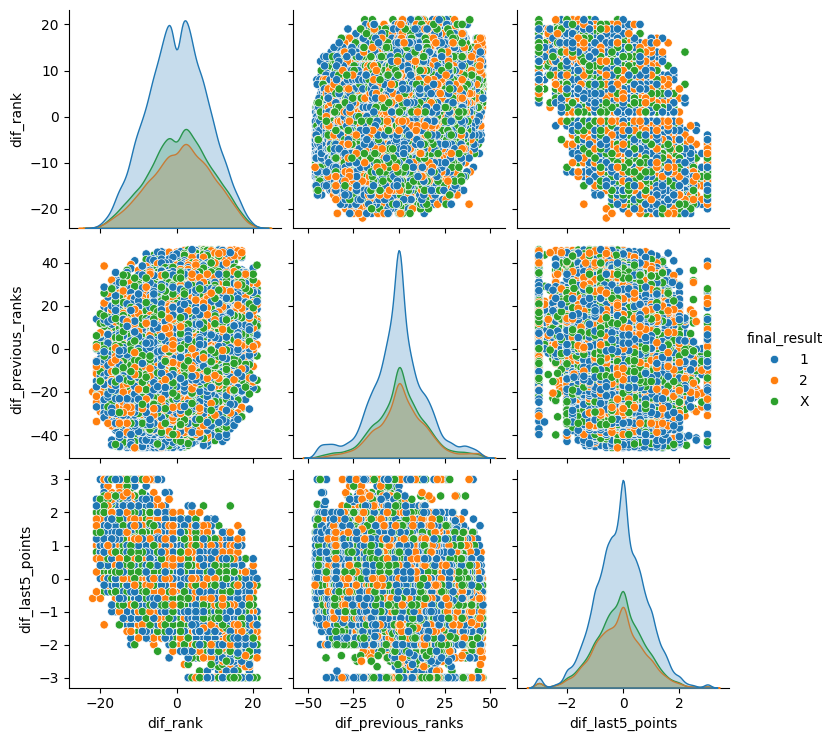

In [116]:
sns.pairplot(test_df[["dif_rank","dif_previous_ranks","dif_last5_points","final_result"]],hue="final_result")

In [122]:
X_train, X_test, y_train, y_test = train_test_split(test_df.drop(["season","division","final_result","home_team","away_team"],axis=1), test_df["final_result"], test_size=0.2, random_state=1)


              precision    recall  f1-score   support

           1       0.53      0.96      0.68      5046
           2       0.33      0.03      0.06      2146
           X       0.28      0.03      0.06      2379

    accuracy                           0.52      9571
   macro avg       0.38      0.34      0.27      9571
weighted avg       0.42      0.52      0.39      9571



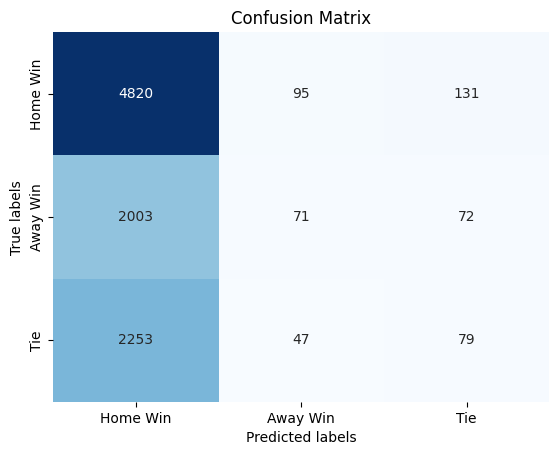

In [123]:

def performance(y_test, y_pred, model):
    # Classification Report shows some metrics to evaluate the model performance
    class_report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    accuracy = class_report['accuracy']

    # Plot Confusion Matrix
    labels = ["Home Win", "Away Win", "Tie"]
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy


RF_model = RandomForestClassifier(n_estimators = 200 ,class_weight='balanced')
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_accuracy = performance(y_test, RF_pred, RF_model)

